### Information Driven Bar Sampling

Information Driven Bar Sampling의 목적은 시장에 새로운 정보가 도달할 경우 더 빈번히 표본을 추출하기 위한 것이다. 여기서 '정보'라는 것은 시장 미시구조 측면에서 사용된다. 나중에 살펴보겠지만, 미시 구조 이론은 불균형한 부호의 거래량이 지속되는 데 주안점을 두고 있는데, 이 현상은 정보 기반 거래자의 존재 여부와 연계돼 있기 때문이다. 표본 추출을 정보기반 거래자의 도착과 연동시키면 가격이 새로운 균형 상태에 이르기 전에 투자 의사결정을 내릴 수 있게 된다. 이번 절에서는 각종 정보 도달 지표를 사용해 어떻게 바를 샘플링하는지 알아본다.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from FinancialMachineLearning.barsampling.core import *

In [2]:
data = pd.read_parquet('../../../Data/IVE_tickbidask.parquet')

In [3]:
data.index = pd.to_datetime(data['date'])

In [4]:
bar = ImbalanceBarFeatures(data)

#### 1. Tick imbalance bar

Tick의 시퀀스 $\{(p_t, \nu_t)\}_{t = 1, \dots, T}$가 있다고 가정해 보자. 여기서 $p_t$는 틱 $t$에 연계된 가격이고, $\nu_t$는 틱 $t$에서의 거래량이다. 이른바 틱 규칙은 다음을 만족하는 $\{b_t\}_{t = 1, \dots, T}$를 정의한다.

$$
b_t=
\begin{cases}
b_{t-1} & \text{ if } \Delta p_t = 0 \\
\frac{\vert \Delta p_t\vert}{\Delta p_t} & \text{ if } \Delta p_t \neq 0 
\end{cases}
$$

여기서 $b_t \in \{-1, 1\}$이고 경계 조건 $b_0$은 바로 직전 바에서의 끝단값 $b_t$와 일치하도록 설정한다. Tick Imbalance Bar의 기본 아이디어는 틱 불균형이 예상을 초과할 때마다 표본 추출한다는 것이다. 여기서는 부호가 있는 틱의 누적값이 주어진 임계값을 넘는 틱 인덱스 값 $T$를 찾고자 한다. 이제 $T$를 결정하는 절차에 대해 알아보자. 

첫째, 시간 $T$에서의 틱 불균형에 대해 다음과 같이 정의한다.

$$
\theta_T = \sum_{t = 1}^T b_t
$$

둘째, 바의 시작점에서의 기대값 $\theta_T$를 다음처럼 계산한다. $E_0[\theta_T] = E_0[T](P[b_t = 1] - P[b_t = -1])$, 여기서 $E_0[T]$는 틱 바의 기대 크기이고, $P[b_t = 1]$은 틱이 매수로 분류될 비조건부 확률이다. 그리고 $P[b_t = -1]$은 틱이 매도로 분류될 비조건부 확률이다. $P[b_t = 1] + P[b_t = -1] = 1$이므로 $E_0[\theta_T] = E_0[T](2P[b_t = 1] - 1)$이다. 실제로 $E_0[T]$는 이전 바들로부터의 $T$ 값의 지수 가중 이동 평균으로 계산할 수 있고, $(2P[b_t = 1] - 1)$은 이전 바들로부터의 $b_t$값의 지수 가중 이동평균으로 계산할 수 있다.

셋째, Tick Imbalance Bar를 다음 조건을 만족하는 틱의 $T^*$-contigous 부분 집합으로 정의한다.

$$T^* {\arg\min}_T \left\{ 
\vert \theta_T \vert \geq E_0[T] \vert 2P[b_t = 1] -1
\right\}$$

여기서 기대 불균형의 크기는 $|2P[b_t = 1] - 1|$로 추정된다. $\theta_T$가 예상보다 더 불균형일 경우 작은 $T$가 이러한 조건을 만족할 것이다. 이에 따라 Tick Imbalance Bar들은 정보 기반 거래자가 있을 경우 더 빈번히 발생한다. 사실 Tick Imbalance Bar를 동일한 정보를 가진 거래의 버킷으로 이해할 수 있다.

In [5]:
tick_imbalance, _ = bar.const_tick_imbalance_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 300
)
tick_imbalance.head()

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 10:00:15,300,50.790,51.210,50.7100,51.21,15312.06,8879.02,300,7.816969e+05
1,09/28/2009 10:02:50,353,51.210,51.260,51.2000,51.25,2714.97,1639.34,53,1.391072e+05
2,09/28/2009 10:14:15,482,51.250,51.290,51.1900,51.26,6611.45,4049.09,129,3.389075e+05
3,09/28/2009 11:14:34,938,51.258,51.380,51.1873,51.34,23387.43,13284.72,456,1.199727e+06
4,09/28/2009 11:51:21,1197,51.340,51.436,51.3000,51.42,13300.61,8679.46,259,6.831386e+05


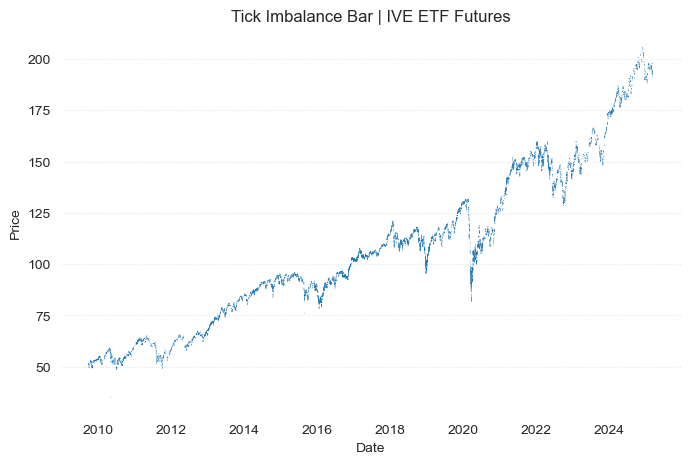

In [6]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(tick_imbalance['date_time']), 
    tick_imbalance.close, s = 1, 
    marker = '.', edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Tick Imbalance Bar | IVE ETF Futures')
plt.show()

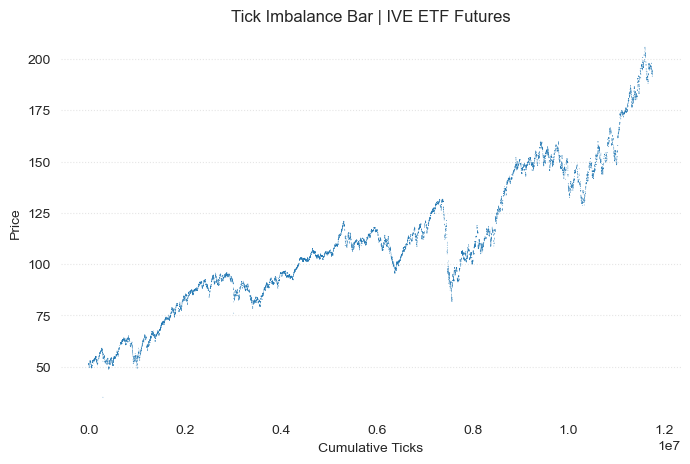

In [7]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tick_imbalance['cum_ticks'].cumsum(), 
    tick_imbalance.close, s = 1, 
    marker = '.', edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Ticks')
plt.ylabel('Price')
plt.title('Tick Imbalance Bar | IVE ETF Futures')
plt.show()

#### 2. Volume Imbalance Bar / Dollar Imbalance Bar

Volume Imbalance Bar와 Dollar Imbalance Bar의 기본 아이디어는 Tick Imbalance Bar의 개념을 확장하는 것이다. 즉 거래량이나 달러의 불균형이 기대값을 벗어날 경우에 표본을 추출하는 것이다. Tick Imbalance Bar에서 논의한 틱 규칙과 경계 조건 $b_0$와 동일한 개념하에 다음 샘플의 index $T$를 결정하는 절차를 정의해 보자.

첫째, 시점 $T$에서의 불균형을 다음과 같이 정의한다.

$$\theta_T = \sum_{t=1}^T b_t \nu_t$$

여기서 $\nu_t$는 거래된 증권의 개수나 혹은 거래된 대금을 나타낸다. $\nu_t$를 무엇으로 결정하느냐에 따라서 전자 혹은 후자에 의해 표본 추출을 수행하게 된다.

둘째, 바의 시작에서 $\theta_T$의 기대값을 계산한다.

$$E_0[\theta_T] = E_0 \left[ 
\sum_{t|b_t = 1}^T \nu_t 
\right] - E_0 \left[ 
\sum_{t|b_t = -1}^T \nu_t 
\right] = E_0[ T](P[b_t = 1]E_0[\nu_t|b_t = 1] - P[b_t=-1]E_0[\nu_t|b_t = -1])$$

$\nu^+ = P[b_t = 1]E_0[\nu_t|b_t = 1], \nu^- = P[b_t = -1]E_0[\nu_t|b_t = -1]$로 표기하면, $E_0[T]^{-1} E_0[\Sigma_t \nu_t]=E_0[\nu_t] = \nu^+ \nu^-$가 된다. $\nu^+$와 $\nu^-$는 초기 기대값 $\nu_t$를 각각 매수와 매도 성분으로 분해한 것으로 생각할 수 있다. 그렇다면 다음이 성립한다.

$$E_0[\theta_T] = E_0[T](\nu^+ - \nu^-) = E_0[T](2\nu^+ - E_0[\nu_t])$$

실제로 $E_0[T]$는 이전 바들로부터의 $T$값의 지수 가중 이동 평균으로 계산할 수 있고, $(2\nu^+ - E_0[\nu_t])$는 이전 바에서 $b_t\nu_t$값의 지수 가중 이동 평균으로 계산할 수 있다.

셋째, VIB나 DIB를 다음 조건을 만족하는 틱의 $T^*$-contigous 부분 집합으로 정의할 수 있다.

$$T^* = \arg \min_T \left\{ 
\vert \theta_T \vert \geq E_0[T]\vert2\nu^+ - E_0[\nu_t] \vert
\right\}$$

여기서 기대 불균형 크기는 $\vert2\nu^+ - E_0[\nu_t] \vert$로 추정된다. $\theta_T$가 예상보다 더 불균형이면 작은 $T$가 이 조건을 만족할 것이다. 이는 정보 기반의 거래량 또는 거래대금 바로 생각할 수 있다. 이전 것들처럼 이 역시 틱 파편화와 이상값으로 인한 동일한 문제점을 해결하려는 것이다. 게다가 기업 행위와 관련된 이슈 또한 해결한다. 앞의 절차는 바 크기가 일정하다는 가정하지 않고, 대신 바 크기를 동적으로 조정한다.

In [8]:
volume_imbalance, _ = bar.const_volume_imbalance_bar(
    expected_imbalance_window = 300, 
    exp_num_ticks_init = 50
)
volume_imbalance.head()

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:42:17,50,50.79,50.85,50.71,50.85,2539.04,1523.34,50,128973.016580
1,09/28/2009 09:44:09,56,50.83,50.91,50.83,50.91,305.19,254.37,6,15525.530400
2,09/28/2009 09:45:03,67,50.91,51.05,50.91,51.05,560.63,560.63,11,28579.419600
3,09/28/2009 09:47:22,99,51.06,51.07,51.05,51.06,1633.70,1429.50,32,83422.339300
4,09/28/2009 10:14:10,475,51.06,51.29,51.06,51.26,19241.17,10440.86,376,984821.664665


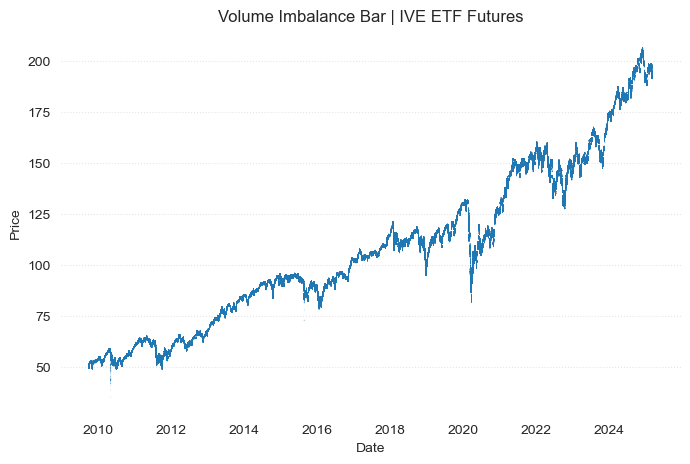

In [9]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(volume_imbalance['date_time']), 
    volume_imbalance.close,
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Volume Imbalance Bar | IVE ETF Futures')
plt.show()

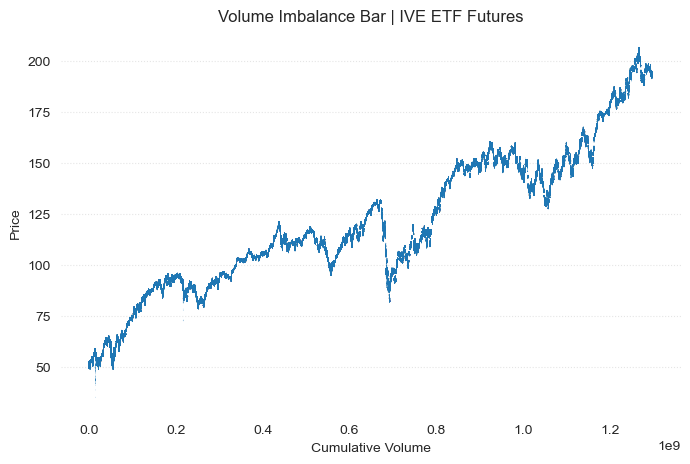

In [10]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    volume_imbalance['volume'].cumsum(), 
    volume_imbalance['close'],
    s = 1, 
    marker = '.', 
    edgecolor = 'none', 
    alpha = 0.5,
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Volume Imbalance Bar | IVE ETF Futures')
plt.show()

#### 3. Dollar imbalance bar

In [11]:
dollar_imbalance, _ = bar.const_dollar_imbalance_bar(
    expected_imbalance_window = 252, 
    exp_num_ticks_init = 63
)
dollar_imbalance

Reading data in batches:
Batch number: 0
Batch number: 1
Returning bars 



,date_time,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
0,09/28/2009 09:45:03,66,50.79,51.05,50.71,51.05,3353.83,2287.31,66,1.704729e+05
1,09/28/2009 09:47:23,103,51.05,51.07,51.05,51.06,1888.93,1684.73,37,9.645387e+04
2,09/28/2009 10:23:40,574,51.06,51.29,51.06,51.25,24108.41,13105.44,471,1.234242e+06
3,09/28/2009 10:31:44,670,51.25,51.35,51.23,51.35,4920.97,2819.69,96,2.522872e+05
4,09/28/2009 10:31:45,683,51.35,51.38,51.35,51.38,667.52,667.52,13,3.428383e+04
...,...,...,...,...,...,...,...,...,...,...
1005082,03/07/2025 15:59:59,11751390,194.14,194.14,194.07,194.07,1358.55,388.17,7,2.636887e+05
1005083,03/07/2025 15:59:59,11751391,194.05,194.05,194.05,194.05,194.05,0.00,1,3.765540e+04
1005084,03/07/2025 16:00:00,11751392,194.05,194.05,194.05,194.05,194.04,0.00,1,3.765346e+04
1005085,03/07/2025 16:00:00,11751393,194.05,194.05,194.05,194.05,194.04,0.00,1,3.765346e+04


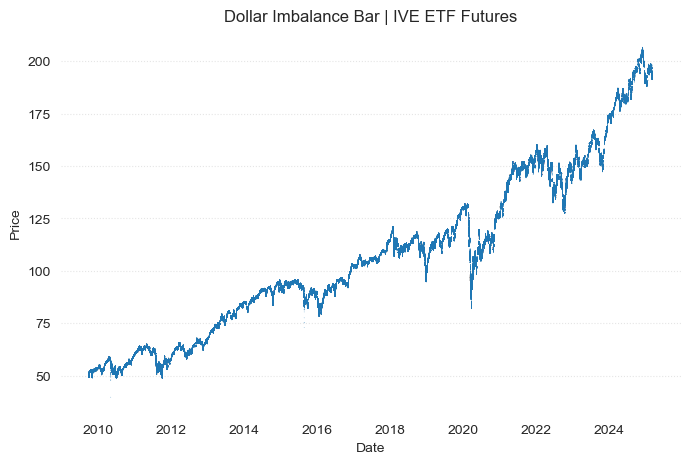

In [12]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    pd.to_datetime(dollar_imbalance['date_time']), 
    dollar_imbalance.close, 
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

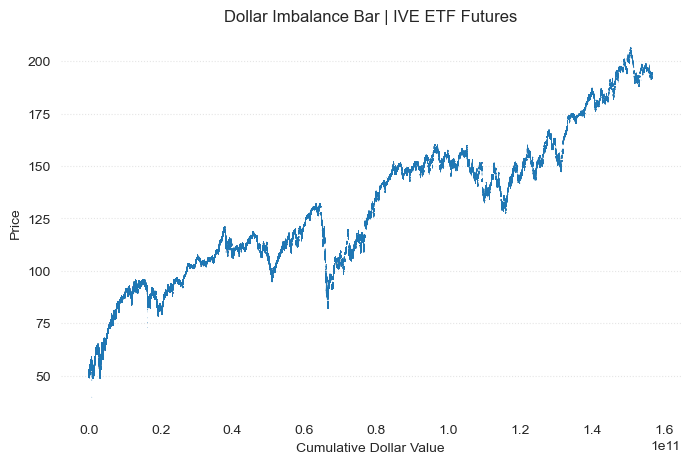

In [13]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    dollar_imbalance['cum_dollar_value'].cumsum(), 
    dollar_imbalance.close, 
    s = 1, 
    marker = '.', 
    edgecolor = 'none',
    alpha = 0.75
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Cumulative Dollar Value')
plt.ylabel('Price')
plt.title('Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

In [15]:
tib_returns = tick_imbalance.close.pct_change().dropna()
vib_returns = volume_imbalance.close.pct_change().dropna()
dib_returns = dollar_imbalance.close.pct_change().dropna()

tib_returns.index = pd.to_datetime(tick_imbalance.date_time[1:])
vib_returns.index = pd.to_datetime(volume_imbalance.date_time[1:])
dib_returns.index = pd.to_datetime(dollar_imbalance.date_time[1:])

In [16]:
tib_standard = (tib_returns - tib_returns.mean())/tib_returns.std()
vib_standard = (vib_returns - vib_returns.mean())/vib_returns.std()
dib_standard = (dib_returns - dib_returns.mean())/dib_returns.std()

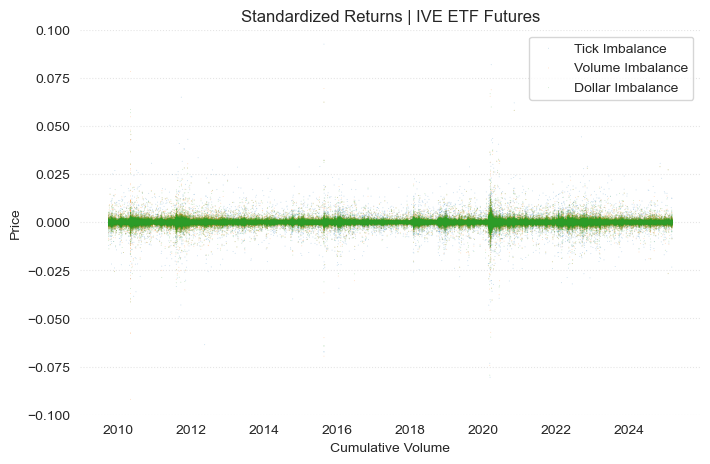

In [17]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.scatter(
    tib_returns.index, 
    tib_returns, 
    s = 2, 
    marker = '.',
    label = 'Tick Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
ax.scatter(
    vib_returns.index,
    vib_returns, 
    s = 2, 
    marker = '.', 
    label = 'Volume Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
ax.scatter(
    dib_returns.index, 
    dib_returns, 
    s = 2, 
    marker = '.', 
    label = 'Dollar Imbalance', 
    alpha = 0.25, 
    edgecolor = 'none'
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5)
plt.ylim([-0.1, 0.1])
plt.legend()
plt.xlabel('Cumulative Volume')
plt.ylabel('Price')
plt.title('Standardized Returns | IVE ETF Futures')
plt.show()

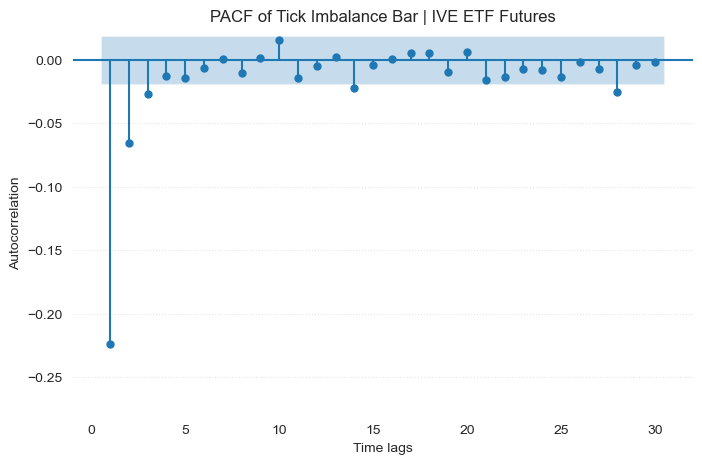

In [18]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    tick_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Tick Imbalance Bar | IVE ETF Futures')
plt.show()

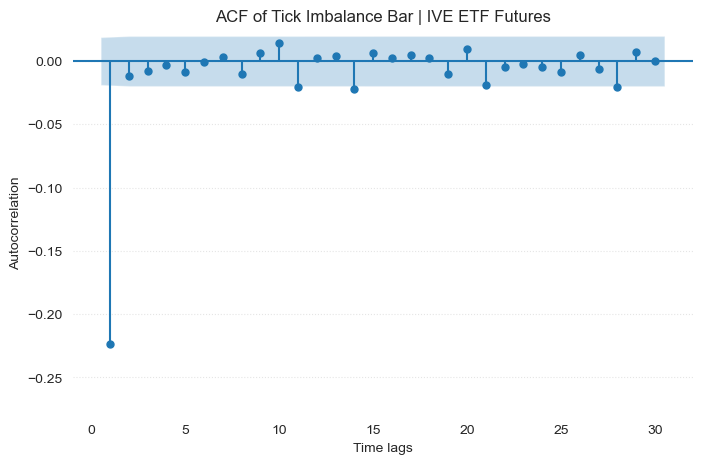

In [19]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    tick_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Tick Imbalance Bar | IVE ETF Futures')
plt.show()

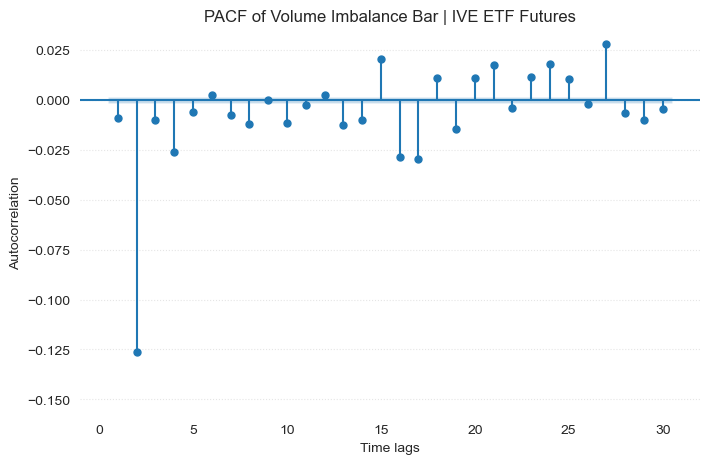

In [20]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    volume_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Volume Imbalance Bar | IVE ETF Futures')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    volume_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Volume Imbalance Bar | IVE ETF Futures')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    dollar_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    dollar_imbalance['close'].pct_change().dropna(), 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Dollar Imbalance Bar | IVE ETF Futures')
plt.show()

Time Bar와의 비교

In [ ]:
time_bar = pd.read_parquet('../../Data/IVE_tickbidask.parquet')

In [ ]:
time_bar.index = pd.to_datetime(time_bar['date'])

In [ ]:
time_30 = time_bar.resample('30min').last()

In [ ]:
time_30 = time_30['price'].dropna().pct_change().dropna()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_pacf(
    time_30, 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('PACF of Time Bar | IVE ETF Futures')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize = (8, 5))
plot_acf(
    time_30, 
    auto_ylims = True, 
    lags = range(1, 31),
    ax = ax
)
for spine in ax.spines.values():
    spine.set_visible(False)
ax.grid(False)
ax.yaxis.grid(True, ls = ':', alpha = 0.5) 
plt.xlabel('Time lags')
plt.ylabel('Autocorrelation')
plt.title('ACF of Time Bar | IVE ETF Futures')
plt.show()